<a href="https://colab.research.google.com/github/Mary-prh/food_classification_transfer-learning-/blob/main/Food_type_detection_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug 10 16:04:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the Data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2022-08-10 16:04:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   272MB/s    in 0.6s    

2022-08-10 16:04:45 (272 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import zipfile

In [4]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
import os
for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirname)} directories and {len(filename)} image in {dirpath}')

there are 2 directories and 0 image in 10_food_classes_10_percent
there are 10 directories and 0 image in 10_food_classes_10_percent/test
there are 0 directories and 250 image in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 image in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 image in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 image in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 image in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 image in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 image in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 image in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 image in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 image in 10_food_classes_10_percent/test/pizza
there are 10 directories and 0 ima

## Load the images in batches

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

### Using Imagedatagenerator

In [7]:
# train_gen = ImageDataGenerator(rescale= 1/255.)
# test_gen =  ImageDataGenerator(rescale= 1/255.)

# Batches = 32
# Image_Shape = (224,224)

# train_dir = "10_food_classes_10_percent/train" 
# test_dir = "10_food_classes_10_percent/test"

# train_data = train_gen.flow_from_directory(train_dir,target_size= Image_Shape,
#                    batch_size=Batches, class_mode='categorical')

# test_data = test_gen.flow_from_directory(test_dir, batch_size = Batches,
#                                          class_mode='categorical', target_size = Image_Shape)

### Using Image_dataset_from_directory
(this is faster and easier to use)

In [8]:
train_dir = "10_food_classes_10_percent/train" 
test_dir = "10_food_classes_10_percent/test"

Batches = 32
Image_Shape = (224,224)

train_data = image_dataset_from_directory(directory= train_dir,label_mode= 'categorical',
                                          batch_size = Batches, image_size = Image_Shape)

test_data = image_dataset_from_directory(directory= test_dir,label_mode= 'categorical',
                                          batch_size = Batches, image_size = Image_Shape)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data.class_names , len(train_data.class_names)

(['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'],
 10)

In [10]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Class_names
**This is not necessary if you use "image_dataset_from_directory" function**

In [11]:
import numpy as np
import pathlib as pl

In [12]:
data_dir = pl.Path('10_food_classes_10_percent/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(f"There are {len(class_names)} classes named {class_names} in the data set.")

There are 10 classes named ['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi'] in the data set.


## Tensorboard Callback

In [13]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# def tensorboard_func(dir_name, model_name):
#   Log_Dir = dir_name + "/" + model_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#   tensorboard_callback = TensorBoard(logdir = Log_Dir)
#   print(f"Saving TensorBoard log files to: {Log_Dir}")
#   return tensorboard_callback

def tensorboard_func(dir_name, model_name):
  Log_Dir = dir_name + '/' + model_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%m%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= Log_Dir)
  print(f"Saving TensorBoard log files to: {Log_Dir}")
  return tensorboard_callback

## View Images Randomly

In [14]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_images_randomly(folder, train_or_test , subfolder):
     # Setup target directory (we'll view images from here)
  target_folder = folder+'/'+train_or_test+'/'+subfolder

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image[0])

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(subfolder)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

1286513.jpg
Image shape: (384, 512, 3)


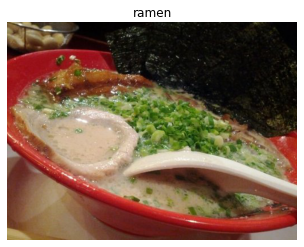

In [15]:
img = view_images_randomly(folder="10_food_classes_10_percent", train_or_test="train",
                           subfolder=random.choice(class_names))

## **Keras Functional API : Model_0**

### 1. Create the base model with tf.keras.application

In [16]:
# Create the base model
model_base = tf.keras.applications.EfficientNetB0(include_top=False)

# we freeze the trained model as is (feature extraction)
model_base.trainable = False

# Create input tensor (Efficientnet does not need normalization)
inputs = tf.keras.layers.Input(shape= (224,224,3),
                               name = 'Input Layer')

# Pass inputs to the base model
x = model_base(inputs)

# Average pooling (
    # this step is actually to condense all the most important features into a feature vector(1D vector)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_Layer')(x)
#x = tf.keras.layers.GlobalMaxPooling2D(name='Global_maxpooling')(x)

# Output
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name= 'output_layer')(x) 

16719872/16705208 [==============================] - 0s 0us/step


**x: number of features**

In [17]:
x.shape , outputs.shape

(TensorShape([None, 1280]), TensorShape([None, 10]))

### 2. Combine the inputs and outputs into  new model

In [18]:
model_0 = tf.keras.Model(inputs, outputs)

### 3. Compile the model

In [19]:
model_0.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',
                metrics = ['accuracy'])

### 4. fit the model

In [20]:
history_0 = model_0.fit(train_data, steps_per_epoch= len(train_data),
                        epochs=5,
                        validation_data = test_data,validation_steps= int(0.25*len(test_data)),
                        callbacks = [tensorboard_func('transfer learning', 'effiecientnetb0_extract')])

Saving TensorBoard log files to: transfer learning/effiecientnetb0_extract/20220810-16081660147551
Epoch 1/5
24/24 [==============================] - 23s 257ms/step - loss: 1.9447 - accuracy: 0.3813 - val_loss: 1.3384 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - 5s 194ms/step - loss: 1.1607 - accuracy: 0.7453 - val_loss: 0.9237 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 4s 156ms/step - loss: 0.8557 - accuracy: 0.7920 - val_loss: 0.7314 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 4s 153ms/step - loss: 0.6966 - accuracy: 0.8280 - val_loss: 0.6338 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 5s 188ms/step - loss: 0.5986 - accuracy: 0.8667 - val_loss: 0.5995 - val_accuracy: 0.8372


In [21]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6055 - accuracy: 0.8360


[0.6054725646972656, 0.8360000252723694]

## Check layers in our base model (normalization and resclaing can be figured out by this loop and checking the layers)

In [22]:
for layer_number, layer in enumerate(model_base.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7f893d9d0550>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f893d985e90>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f893d940190>
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f893f452850>
4 <keras.layers.convolutional.Conv2D object at 0x7f893d962150>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f893f083150>
6 <keras.layers.core.activation.Activation object at 0x7f893d940d10>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f893dbcce50>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f893dbc8390>
9 <keras.layers.core.activation.Activation object at 0x7f893d985f90>
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f893dbc8290>
11 <keras.layers.core.reshape.Reshape object at 0x7f893d8a1550>
12 <keras.layers.convolutional.Conv2D object at 0x7f893da04f90>
13 <keras.layers.convolutional

In [23]:
# sumary of the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_Laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Plots and evaluation

In [24]:
import pandas as pd

losses = pd.DataFrame(history_0.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,1.944663,0.381333,1.338377,0.702303
1,1.160650,0.745333,0.923707,0.776316
2,0.855667,0.792000,0.731357,0.828947
3,0.696619,0.828000,0.633798,0.832237
4,0.598566,0.866667,0.599526,0.837171


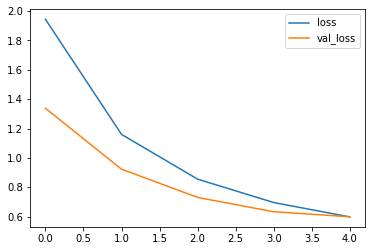

In [25]:
losses[['loss','val_loss']].plot()

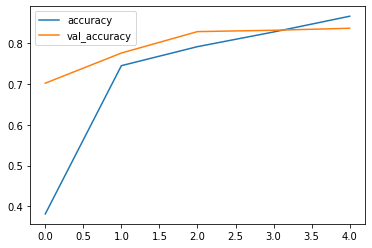

In [26]:
losses[['accuracy', 'val_accuracy']].plot()

# **Keras Functional API: Model_1**

## Get the data
(1% of the training dataset)

In [27]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-08-10 16:07:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.3MB/s    in 12s     

2022-08-10 16:07:15 (10.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [28]:
import zipfile
zip = zipfile.ZipFile('10_food_classes_1_percent.zip')
zip.extractall()
zip.close()

## data batches

In [29]:
train_dir_1p = '10_food_classes_1_percent/train'
test_dir_1p = '10_food_classes_1_percent/test'

Batches = 32
Image_Shape = (224, 224)

train_data_1p = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir_1p,
                                                                    label_mode = 'categorical',
                                                                    batch_size = Batches, 
                                                                    image_size = Image_Shape)

test_data_1p = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir_1p,
                                                                    label_mode = 'categorical',
                                                                    batch_size = Batches, 
                                                                    image_size = Image_Shape)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
train_data_1p.class_names , train_data_1p

(['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'],
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

## Data Augmentation

tf.keras.layers.experimental.preprocessing

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [32]:
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomWidth(0.2)], name ="data_augmentation")

## API

**1. Create the base model with tf.keras.application**

In [33]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [34]:
Inputs = tf.keras.layers.Input(shape = Image_Shape + (3,), name= 'Input_layer')

x = data_augmentation(Inputs)

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAvgPool2D(name = 'Pooling_Average')(x)

Outputs = tf.keras.layers.Dense(10, activation= 'softmax')(x)

**2. Combine the inputs and outputs into new model**

In [35]:
model_1 = keras.Model(Inputs, Outputs)

**3. Compile the model**

In [36]:
model_1.compile(optimizer= 'Adam', loss= 'categorical_crossentropy', 
                metrics = ['accuracy'])

**4. Fit the model**

In [37]:
history_1 = model_1.fit(train_data_1p, steps_per_epoch= len(train_data_1p),
                        epochs=5,
                        validation_data = test_data_1p,validation_steps= int(0.25*len(test_data_1p)),
                        callbacks = [tensorboard_func('transfer learning', 'model_1_effiecientnetb0_extract')])

Saving TensorBoard log files to: transfer learning/model_1_effiecientnetb0_extract/20220810-16081660147639
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.3719 - accuracy: 0.0857 - val_loss: 2.2798 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0983 - accuracy: 0.2571 - val_loss: 2.1454 - val_accuracy: 0.2533
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8951 - accuracy: 0.4429 - val_loss: 2.0460 - val_accuracy: 0.3289
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7206 - accuracy: 0.6429 - val_loss: 1.9460 - val_accuracy: 0.3799
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5932 - accuracy: 0.6857 - val_loss: 1.8644 - val_accuracy: 0.4128


## Evaluation

In [38]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_Average (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [39]:
result_on_whole_test = model_1.evaluate(test_data_1p)

79/79 [==============================] - 6s 74ms/step - loss: 1.8509 - accuracy: 0.4416


## Plots

In [40]:
losses = pd.DataFrame(history_1.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,2.371949,0.085714,2.279810,0.172697
1,2.098257,0.257143,2.145374,0.253289
2,1.895138,0.442857,2.046034,0.328947
3,1.720619,0.642857,1.946006,0.379934
4,1.593227,0.685714,1.864449,0.412829


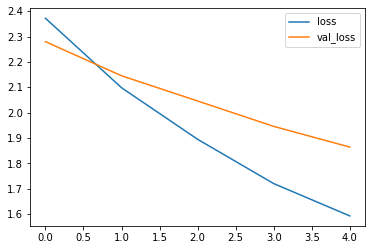

In [41]:
losses[['loss','val_loss']].plot()

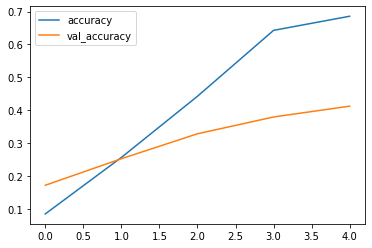

In [42]:
losses[['accuracy','val_accuracy']].plot()

# **Keras Functional API: Model_2**

## Get the data

In [43]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2022-08-10 16:08:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   238MB/s    in 0.7s    

2022-08-10 16:08:07 (238 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [44]:
import zipfile
zip = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip.extractall()
zip.close()

## Data Batches

In [45]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [46]:
train_10p_dir = '10_food_classes_10_percent/train'
test_10p_dir = '10_food_classes_10_percent/test'

Batches = 32
Image_Shape = (224,224)

train_data_10p = image_dataset_from_directory(directory= train_10p_dir , label_mode= 'categorical',
                                              batch_size = Batches, image_size = Image_Shape)

test_data_10p = image_dataset_from_directory(directory= test_10p_dir , label_mode= 'categorical',
                                             batch_size = Batches, image_size = Image_Shape)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [47]:
train_data_10p.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Data Augmentation

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , Sequential
from tensorflow.keras.layers import experimental 
from tensorflow.keras.layers.experimental import preprocessing

In [49]:
data_augmentation = Sequential([preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomRotation(0.2),
                                #preprocessing.Rescaling(1/225.)
                                ], name= "Data_Augmentation")

### view random images

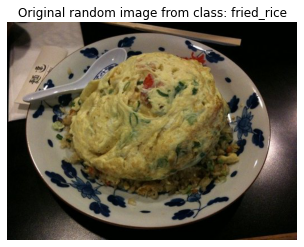

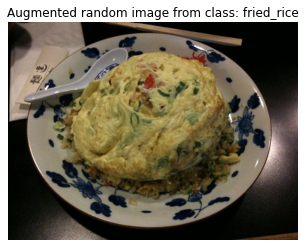

In [50]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_10p.class_names) # choose a random class
target_dir = "10_food_classes_10_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## API


**1. Create the base model with tf.keras.applications**

In [51]:
from tensorflow.keras import applications

In [52]:
base_model = applications.EfficientNetB0(include_top= False)

base_model.trainable = False

In [53]:
Inputs = tf.keras.layers.Input(shape= Image_Shape + (3,) , name = 'Input_layer')

x = data_augmentation(Inputs)

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAveragePooling2D (name = 'average_pooling')(x)

Outputs = tf.keras.layers.Dense(10, activation= 'softmax', name = 'Output_layer')(x)

**2. Combine the inputs and outputs into new model**

In [54]:
model_2 = keras.Model(Inputs, Outputs)

**3. Compile the model**

In [55]:
model_2.compile(optimizer= 'Adam', loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

**4. Fit the model**

**The ModelCheckpoint callback gives you the ability to save the model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.**

In [56]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 
# note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [57]:
history_2 = model_2.fit(train_data_10p, steps_per_epoch= len(train_data_10p),
                        validation_data = test_data_10p , 
                        validation_steps= int(0.25 * len(test_data_10p)),
                        epochs = 5,
                        callbacks = [tensorboard_func(dir_name= 'transfer learning', model_name= 'M2_efficientnetB0'), 
                                     checkpoint_callback]
                        )

Saving TensorBoard log files to: transfer learning/M2_efficientnetB0/20220810-16081660147692
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9940 - accuracy: 0.3560
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 539ms/step - loss: 1.9940 - accuracy: 0.3560 - val_loss: 1.5331 - val_accuracy: 0.5855
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.6587
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 418ms/step - loss: 1.3746 - accuracy: 0.6587 - val_loss: 1.1140 - val_accuracy: 0.7303
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0750 - accuracy: 0.7480
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 454ms/step - loss: 1.0750 - accuracy: 0.7480 - val_loss: 0.9238 - val_accuracy: 0.

# **Keras Functional API: Model_3**

**everything about the data is the same but we are fine tunning the model_2**

## API

**1. Create the base model with tf.keras.applications while the last 10 layers are unfrozen**

In [58]:
from tensorflow.keras import applications

In [59]:
base_model = applications.EfficientNetB0(include_top = False)

In [60]:
for layers in base_model.layers[:-10]:
  layers.trainable = False

In [61]:
for layers in base_model.layers:
  if layers.trainable == True:
    print(layers)

In [62]:
Image_Shape = (224,224)
Batches = 32

Inputs = tf.keras.layers.Input(shape= Image_Shape + (3,), name = "Input_later")

x = data_augmentation(Inputs)

x = base_model(x,training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = 'average_pooling')(x)

Output = tf.keras.layers.Dense(10, activation= 'softmax', name= "Output_layer")(x)

**2. Combine the inputs and outputs into new model**

---



In [63]:
model_3 = keras.Model(Inputs,Output)

**3. Compile the model**

In [64]:
model_3.compile (optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
                 loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [65]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [66]:
print(len(model_3.trainable_variables))

12


In [67]:
# Fine tune for another 5 epochs
initial_epochs = 3 
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_3 = model_3.fit(train_data_10p,
                        epochs=fine_tune_epochs,
                        validation_data=test_data_10p,
                        initial_epoch=history_2.epoch[-1], # start from previous last epoch
                         validation_steps=int(0.25 * len(test_data_10p)),
                         callbacks=[tensorboard_func("transfer_learning", "10_percent_fine_tune_last_10")]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220810-16081660147762
Epoch 5/8
24/24 [==============================] - 19s 465ms/step - loss: 2.0967 - accuracy: 0.2973 - val_loss: 1.7864 - val_accuracy: 0.4984
Epoch 6/8
24/24 [==============================] - 9s 349ms/step - loss: 1.5473 - accuracy: 0.5907 - val_loss: 1.2867 - val_accuracy: 0.6365
Epoch 7/8
24/24 [==============================] - 8s 303ms/step - loss: 1.0953 - accuracy: 0.6973 - val_loss: 0.9242 - val_accuracy: 0.7286
Epoch 8/8
24/24 [==============================] - 9s 350ms/step - loss: 0.8823 - accuracy: 0.7307 - val_loss: 0.7950 - val_accuracy: 0.7697


# **Keras Functional API: Model_4**

## Get the data

In [68]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-08-10 16:10:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.251.120.128, 64.233.182.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   260MB/s    in 1.9s    

2022-08-10 16:10:14 (260 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [69]:
import zipfile

data = zipfile.ZipFile('10_food_classes_all_data.zip')
data.extractall()
data.close()

## Data Batches

In [70]:
train_all_dir = '10_food_classes_all_data/train'
test_all_dir = '10_food_classes_all_data/test'

from tensorflow.keras.preprocessing import image_dataset_from_directory

Batches = 32
Image_Shape = (224, 224)
train_all = image_dataset_from_directory(train_all_dir, label_mode='categorical',
                                         batch_size = Batches, image_size = Image_Shape)

test_all = image_dataset_from_directory(test_all_dir, label_mode='categorical',
                                         batch_size = Batches, image_size = Image_Shape)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [71]:
train_all.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Data Augmentation

In [72]:
from tensorflow.keras import layers , Sequential
from tensorflow.keras.layers import experimental
from tensorflow.keras.layers.experimental import preprocessing


In [73]:
data_augmentation = Sequential([preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomFlip('horizontal')], name= 'Data_Augmentation')

## API

**1. Create the base model with tf.keras.applications while the last 10 layers are unfrozen**

In [74]:
from tensorflow.keras import applications

In [75]:
base_model = applications.EfficientNetB0(include_top=False)
base_model.trainable = True

for layers in base_model.layers[:-10]:
  layers.trainable = False

for layers in base_model.layers:
  if layers.trainable == True:
    print(layers)


In [76]:
Inputs = tf.keras.layers.Input(shape = Image_Shape + (3,) , name = 'Input_Layer')

x = data_augmentation(Inputs)

x = base_model(x)

x = tf.keras.layers.GlobalAveragePooling2D(name = 'Average_pooling_layer')(x)

Outputs = tf.keras.layers.Dense(10 , activation= 'softmax', name= 'Output_layer')(x)


**2. Combine the inputs and outputs into new model**

In [77]:
model_4 = keras.Model(Inputs,Outputs)

**3. Compile the model**

In [78]:
model_4.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), 
                loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [79]:
for layer_number, layer in enumerate(model_4.layers):
  print(layer_number, layer.name, layer.trainable)

0 Input_Layer True
1 Data_Augmentation True
2 efficientnetb0 True
3 Average_pooling_layer True
4 Output_layer True


In [80]:
print(len(model_4.trainable_variables))

12


**4. Fit the model**

In [81]:
history_4 = model_4.fit(train_all , epochs= 10, steps_per_epoch= len(train_all),
                        validation_data = test_all , validation_steps= int(0.25 * len(test_all)),
                        callbacks=[tensorboard_func("transfer_learning", "fine_tune_All_Data")])

Saving TensorBoard log files to: transfer_learning/fine_tune_All_Data/20220810-16081660147822
Epoch 1/10
235/235 [==============================] - 66s 250ms/step - loss: 1.3232 - accuracy: 0.6153 - val_loss: 0.5847 - val_accuracy: 0.8289
Epoch 2/10
235/235 [==============================] - 49s 207ms/step - loss: 0.7728 - accuracy: 0.7633 - val_loss: 0.4174 - val_accuracy: 0.8602
Epoch 3/10
235/235 [==============================] - 47s 196ms/step - loss: 0.6601 - accuracy: 0.7919 - val_loss: 0.3847 - val_accuracy: 0.8766
Epoch 4/10
235/235 [==============================] - 40s 169ms/step - loss: 0.6031 - accuracy: 0.8084 - val_loss: 0.3448 - val_accuracy: 0.8849
Epoch 5/10
235/235 [==============================] - 41s 172ms/step - loss: 0.5434 - accuracy: 0.8287 - val_loss: 0.3268 - val_accuracy: 0.8931
Epoch 6/10
235/235 [==============================] - 37s 157ms/step - loss: 0.5275 - accuracy: 0.8324 - val_loss: 0.3263 - val_accuracy: 0.8914
Epoch 7/10
235/235 [================

## Evaluation

In [82]:
model_4.evaluate(test_all)

79/79 [==============================] - 6s 74ms/step - loss: 0.2730 - accuracy: 0.9084


[0.272953599691391, 0.9083999991416931]

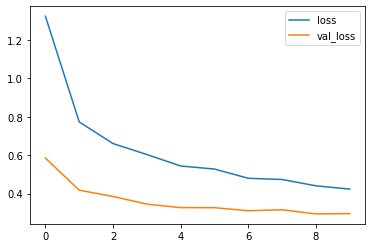

In [83]:
import pandas as pd

losses = pd.DataFrame(history_4.history)
losses[['loss', 'val_loss']].plot()


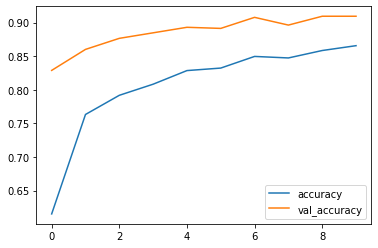

In [84]:
losses[['accuracy', 'val_accuracy']].plot()

## Viewing the experiment on Tensorboard

In [85]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=ainavlAt9UpOjdmIUaY9uq5qveQ6ss&prompt=consent&access_type=o